In [1]:
import dicom
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook
import scipy.misc
from skimage import io
import scipy.stats
import seaborn as sns
import skimage.color
from skimage.filters import threshold_otsu
import keras

from matplotlib import animation
from IPython.display import HTML
from PIL import Image
import pandas as pd
import nibabel as nib
from nibabel.testing import data_path
import dill

Using TensorFlow backend.


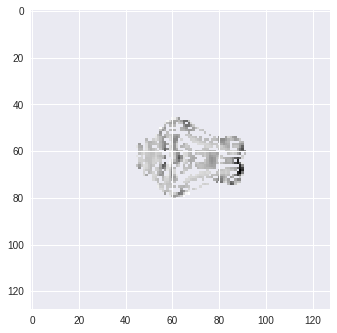

In [2]:
realigned_atlas = nib.load('../Data/big_atlas/coregistered_pig_2_atlas.nii').get_data()
#original_atlas = nib.load('../../Data/big_atlas/atlas.nii').get_data()
anatomical = nib.load('../Data/pig_2/coregistered_anatomy.nii').get_data()
mean_fmri = nib.load('../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii').get_data()  

mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)
fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), mean_fmri) 
# print(fmri_masked_roi)
plt.imshow(fmri_masked_roi[:,:,10])

In [3]:
# let's try loading the entire thing to ram
# the big tensor will have dimension [time, height, width, depth]

im = mean_fmri
all_data = np.zeros((300, im.shape[0], im.shape[1], im.shape[2]))
masked_data = np.ma.zeros((300, im.shape[0], im.shape[1], im.shape[2]))

dicom_files = [x for x in Path('../Data/pig_2/rfmri nii/').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
dicom_files.sort(key=str)
time_index = 0
mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)

for f in tqdm_notebook(dicom_files):
    time_file = nib.load(str(f)).get_data()
    fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), time_file) 
    try:
        masked_data[time_index, ...] = fmri_masked_roi
        all_data[time_index, ...] = time_file
        time_index += 1
    except:
        print(f)

../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii



In [4]:
assert all_data.shape == (300, 128, 128, 20) #300 time samples, 128x128 image, over 20 slices in z-index
assert masked_data.shape == (300, 128, 128, 20) # basic sanity check

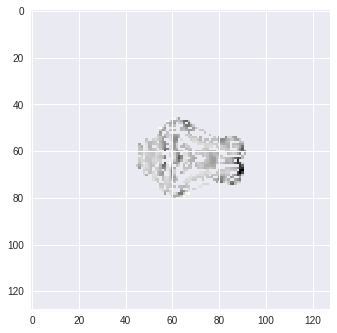

In [5]:
plt.imshow(masked_data[1,:,:,10]) # Mask is generated from an atlas, atlas disregards certain subcortical regions that are just "grey matter"

In [6]:
indices = masked_data[1,:,:,:].nonzero()
df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['row', 'col', 'depth'])
series_df = pd.Series(index=df_index, dtype=object)

for i, triple in tqdm_notebook(enumerate(zip(*indices)), total=len(indices[0])):
    x, y, z = triple
    trace = all_data[:, x, y, z]
    
    series_df.loc[triple] = trace

data_block = np.vstack(series_df.values)[..., np.newaxis]



In [12]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import quniform
from keras.callbacks import LearningRateScheduler

import math

def data():
    realigned_atlas = nib.load('../Data/big_atlas/coregistered_pig_2_atlas.nii').get_data()
    mean_fmri = nib.load('../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii').get_data()  

    mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)
    fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), mean_fmri)
    
    im = mean_fmri
    all_data = np.zeros((300, im.shape[0], im.shape[1], im.shape[2]))
    masked_data = np.ma.zeros((300, im.shape[0], im.shape[1], im.shape[2]))

    dicom_files = [x for x in Path('../Data/pig_2/rfmri nii/').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
    dicom_files.sort(key=str)
    time_index = 0
    mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)

    for f in dicom_files:
        time_file = nib.load(str(f)).get_data()
        fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), time_file) 
        try:
            masked_data[time_index, ...] = fmri_masked_roi
            all_data[time_index, ...] = time_file
            time_index += 1
        except:
            print(f)
    
    
    indices = masked_data[1,:,:,:].nonzero()
    df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['row', 'col', 'depth'])
    series_df = pd.Series(index=df_index, dtype=object)

    for i, triple in enumerate(zip(*indices)):
        x, y, z = triple
        trace = all_data[:, x, y, z]

        series_df.loc[triple] = trace
    data_block = np.vstack(series_df.values)[..., np.newaxis]
    
    shuffled_data = np.copy(data_block)
    np.random.shuffle(shuffled_data)

    testing_set = shuffled_data[:700]  #hold back 700 for validation
    training_set = shuffled_data[700:]
    
    x_train = training_set
    y_train = training_set
    
    x_test = testing_set
    y_test = testing_set
    
    return x_train, y_train, x_test, y_test
    
    

def model(x_train, y_train, x_test, y_test):
    from keras.layers.convolutional import Conv1D, UpSampling1D
    from keras.layers.pooling import MaxPooling1D
    from keras.layers.core import Dense, Activation
    from keras.layers.normalization import BatchNormalization
    
    model = keras.models.Sequential()
    
    c1_size = int({{quniform(50, 70, 1)}})
    c1_length = int({{quniform(3, 15, 2)}})
    
    c2_size = int({{quniform(20, 40, 1)}})
    c2_length = int({{quniform(3, 15, 2)}})
    
    c3_size = int({{quniform(10, 30, 1)}})
    c3_length = int({{quniform(3, 15, 2)}})
    
    c4_size = int({{quniform(1, 8, 1)}})
    c4_length = int({{quniform(3, 15, 2)}})
      
    # encoder
    model.add(Conv1D(c1_size, c1_length, 
                     padding='causal', input_shape=[300, 1])) #Dimensionality 300
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv1D(c2_size, c2_length, 
                     padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    
    model.add(Conv1D(c3_size, c3_length, 
                     padding='causal')) # Activation map size [150 x 1]
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    
    model.add(Conv1D(c4_size, c4_length, 
                     padding='causal')) # Activation map size [75 x 1]
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3))
    
    # Activation map size [25 x 1] 
    # Encoding represenation size is [25 x 1 x N (8)] = 200
    # Dimensionality reduction of 300 -> 200
    
    # decoder
    model.add(Conv1D(c4_size, c4_length, 
                     padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling1D(size=3))
    
    model.add(Conv1D(c3_size, c3_length, 
                     padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling1D())
    
    model.add(Conv1D(c2_size, c2_length, 
                     padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling1D())
    
    model.add(Conv1D(c1_size, c1_length, 
                     padding='causal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv1D(1, 1, padding='causal'))
    model.add(Activation('linear'))
    
    # section 2.1 mentions a special regularization, but I don't think that is going to work
    # the feature map in the compressed representation and the output will not be timeshuffled if we use causal conv
    
    # learning rate schedule
    def step_decay(epoch):
        initial_lrate = 0.01
        drop = 0.5
        epochs_drop = 10.0
        lrate = initial_lrate * drop**(np.floor((1+epoch)/epochs_drop))
        return lrate
    
    lrate = LearningRateScheduler(step_decay)
    callbacks_list = [lrate, keras.callbacks.TerminateOnNaN()]
    
    model.compile(optimizer={{choice(['rmsprop', 'adam', 'sgd'])}}, loss='mse')
    model.fit(x_train, y_train, epochs=4, batch_size={{choice([32, 64, 128, 256])}}, 
              callbacks=callbacks_list, validation_data=(x_test, x_test), verbose=2)
    
    loss = model.evaluate(x_test, x_test)
    
    if np.isnan(loss):
        loss = float('inf')
        
    
    return {'loss': loss, 'status': STATUS_OK, 'model': model}

    

In [ ]:
from hyperopt.mongoexp import MongoTrials

# getting this thing to work with mongotrials is NonTrivial, but also NonImpossible
# trials = MongoTrials('mongo://localhost:1234/foo_db/jobs', exp_key='exp1')

best_run, best_model = optim.minimize(model=model, data=data, algo=tpe.suggest, 
                                      max_evals=100, trials=Trials(),
                                     notebook_name='Experiment 11 - hyperopt', verbose=True)
    

>>> Imports:
#coding=utf-8

try:
    import dicom
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from pathlib import Path
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    from tqdm import tqdm_notebook
except:
    pass

try:
    import scipy.misc
except:
    pass

try:
    from skimage import io
except:
    pass

try:
    import scipy.stats
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    import skimage.color
except:
    pass

try:
    from skimage.filters import threshold_otsu
except:
    pass

try:
    import keras
except:
    pass

try:
    from matplotlib import animation
except:
    pass

try:
    from IPython.display import HTML
except:
    pass

try:
    from PIL import Image
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import nibabel as nib
except:
    pass

try:
    from nibabel.testing import data_path
except

Train on 6455 samples, validate on 700 samples
Epoch 1/4
Batch 2: Invalid loss, terminating training
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/4
12s - loss: 3356706.2145 - val_loss: 1526904.6400
Epoch 2/4
12s - loss: 3257246.0615 - val_loss: 2121787.2671
Epoch 3/4
12s - loss: 3132801.5151 - val_loss: 1473245.0371
Epoch 4/4
11s - loss: 2978407.9351 - val_loss: 1770156.2657
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/4
20s - loss: 3171468.7251 - val_loss: 1381114.3629
Epoch 2/4
19s - loss: 2033315.1925 - val_loss: 8312032.0971
Epoch 3/4
19s - loss: 731120.1392 - val_loss: 4198831.1086
Epoch 4/4
19s - loss: 160295.3274 - val_loss: 856713.6504
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/4
14s - loss: 3214746.4188 - val_loss: 9985950.9086
Epoch 2/4
14s - loss: 2197943.3811 - val_loss: 4314161.2514
Epoch 3/4
1

672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/4
Batch 2: Invalid loss, terminating training
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/4
12s - loss: 3346230.8887 - val_loss: 3237025.4043
Epoch 2/4
11s - loss: 3091296.1851 - val_loss: 1054230.6357
Epoch 3/4
11s - loss: 2555714.2621 - val_loss: 151333.2580
Epoch 4/4
11s - loss: 1875465.8949 - val_loss: 262911.0925
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/4
Batch 2: Invalid loss, terminating training
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/4
13s - loss: 3373825.5829 - val_loss: 2073506.0493
Epoch 2/4
11s - loss: 3311148.7554 - val_loss: 1175596.6536
Epoch 3/4
12s - loss: 3172412.7361 - val_loss: 172724.6818
Epoch 4/4
12s - loss: 2965606.3600 - val_loss: 417383.7575
672/700 [===================

15s - loss: 3168840.3429 - val_loss: 2875183.6086
Epoch 2/4
13s - loss: 2431255.1583 - val_loss: 1747704.8129
Epoch 3/4
14s - loss: 1458984.7005 - val_loss: 661642.1739
Epoch 4/4
14s - loss: 563391.8797 - val_loss: 376971.5020
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/4
13s - loss: 3335655.0179 - val_loss: 3084930.6729
Epoch 2/4
11s - loss: 3050510.5366 - val_loss: 1987980.0736
Epoch 3/4
11s - loss: 2398050.1065 - val_loss: 1611629.0536
Epoch 4/4
11s - loss: 1591466.9399 - val_loss: 136612.3683
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/4
16s - loss: 3375644.7647 - val_loss: 1635196.4186
Epoch 2/4
14s - loss: 3314278.0677 - val_loss: 1750288.3793
Epoch 3/4
13s - loss: 3191116.8808 - val_loss: 648626.2461
Epoch 4/4
14s - loss: 2995854.8965 - val_loss: 4661492.1771
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoc